In [3]:
import pandas as pd
import numpy as np
import math

# ======================
# 1. Load dataset
# ======================
df = pd.read_csv("EV_Charging Demand Forecasting_DATASET.csv")

# Standardize column names
df.columns = [c.strip() for c in df.columns]

# Fix Temperature column (remove encoding issues)
if "Temperature (Â°C)" in df.columns:
    df["Temperature (°C)"] = pd.to_numeric(df["Temperature (Â°C)"], errors="coerce")
    df.drop(columns=["Temperature (Â°C)"], inplace=True)

# ======================
# 2. Clean datetime cols
# ======================
df["Charging Start Time"] = pd.to_datetime(df["Charging Start Time"], errors="coerce")
df["Charging End Time"] = pd.to_datetime(df["Charging End Time"], errors="coerce")

df = df.dropna(subset=["Charging Start Time", "Charging End Time"]).reset_index(drop=True)

# ======================
# 3. Add Weather Condition
# ======================
def get_weather(temp):
    if pd.isna(temp):
        return "Unknown"
    elif temp < 10:
        return "Cold/Clear"
    elif 10 <= temp < 20:
        return "Cloudy"
    elif 20 <= temp < 28:
        return "Sunny"
    elif temp >= 28:
        return "Hot"
    else:
        return "Clear"

df["Weather_Condition"] = df["Temperature (°C)"].apply(get_weather)

# ======================
# 4. Handle missing values
# ======================
# Numeric -> mean/median
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isna().sum() > 0:
        if abs(df[col].skew()) > 1:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mean())

# Categorical -> mode
for col in df.select_dtypes(include="object").columns:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

# ======================
# 5. Compute Charging Duration if missing
# ======================
if "Charging Duration (hours)" not in df.columns:
    df["Charging Duration (hours)"] = (df["Charging End Time"] - df["Charging Start Time"]).dt.total_seconds() / 3600
else:
    df["Charging Duration (hours)"] = pd.to_numeric(df["Charging Duration (hours)"], errors="coerce")
    missing_mask = df["Charging Duration (hours)"].isna() | (df["Charging Duration (hours)"] <= 0)
    df.loc[missing_mask, "Charging Duration (hours)"] = (df["Charging End Time"] - df["Charging Start Time"]).dt.total_seconds() / 3600

# ======================
# 6. Expand sessions to hourly demand
# ======================
def expand_session_to_hours(row):
    start = row["Charging Start Time"]
    end = row["Charging End Time"]
    if pd.isna(start) or pd.isna(end) or end <= start:
        return None
    hour_start = start.floor("h")
    hour_end = end.ceil("h")
    hours = pd.date_range(hour_start, hour_end, freq="h", inclusive="left")
    total_seconds = (end - start).total_seconds()
    if total_seconds <= 0:
        return None
    energy = row.get("Energy Consumed (kWh)", 0.0)
    out = []
    for h in hours:
        overlap_start = max(start, h)
        overlap_end = min(end, h + pd.Timedelta(hours=1))
        overlap_seconds = (overlap_end - overlap_start).total_seconds()
        if overlap_seconds > 0:
            energy_alloc = energy * (overlap_seconds / total_seconds)
            out.append({
                "ds": h,
                "Charging Station ID": row.get("Charging Station ID", None),
                "energy_kwh": energy_alloc
            })
    return pd.DataFrame(out) if out else None

expanded_list = []
for _, row in df.iterrows():
    ex = expand_session_to_hours(row)
    if ex is not None:
        expanded_list.append(ex)

expanded = pd.concat(expanded_list, ignore_index=True)

# ======================
# 7. Aggregate demand
# ======================
# Network level
network_hourly = expanded.groupby("ds", as_index=False)["energy_kwh"].sum().rename(columns={"energy_kwh": "y"})

# Per-station
station_hourly = expanded.groupby(["Charging Station ID", "ds"], as_index=False)["energy_kwh"].sum().rename(columns={"energy_kwh": "y"})

# ======================
# 8. Save final cleaned datasets
# ======================
df.rename(columns={
    "Charging Start Time": "Charging_Start",
    "Charging End Time": "Charging_End",
    "Energy Consumed (kWh)": "Energy_kWh",
    "Charging Duration (hours)": "Charging_Duration_hours"
}, inplace=True)

df.to_csv("final_session_level.csv", index=False)            # cleaned + weather
network_hourly.to_csv("final_network_hourly.csv", index=False) # hourly demand
station_hourly.to_csv("final_station_hourly.csv", index=False) # per-station demand

print("✅ Saved files:")
print("- final_session_level.csv (cleaned + weather)")
print("- final_network_hourly.csv (network hourly demand)")
print("- final_station_hourly.csv (station-level hourly demand)")


✅ Saved files:
- final_session_level.csv (cleaned + weather)
- final_network_hourly.csv (network hourly demand)
- final_station_hourly.csv (station-level hourly demand)


Dataset shapes:
Sessions: (572, 21)
Network hourly: (8088, 2)
Station hourly: (29122, 3)

Total Energy Consumed (kWh):
Session-level: 24,920.95
Network-hourly: 24,920.95
Station-hourly: 24,920.95


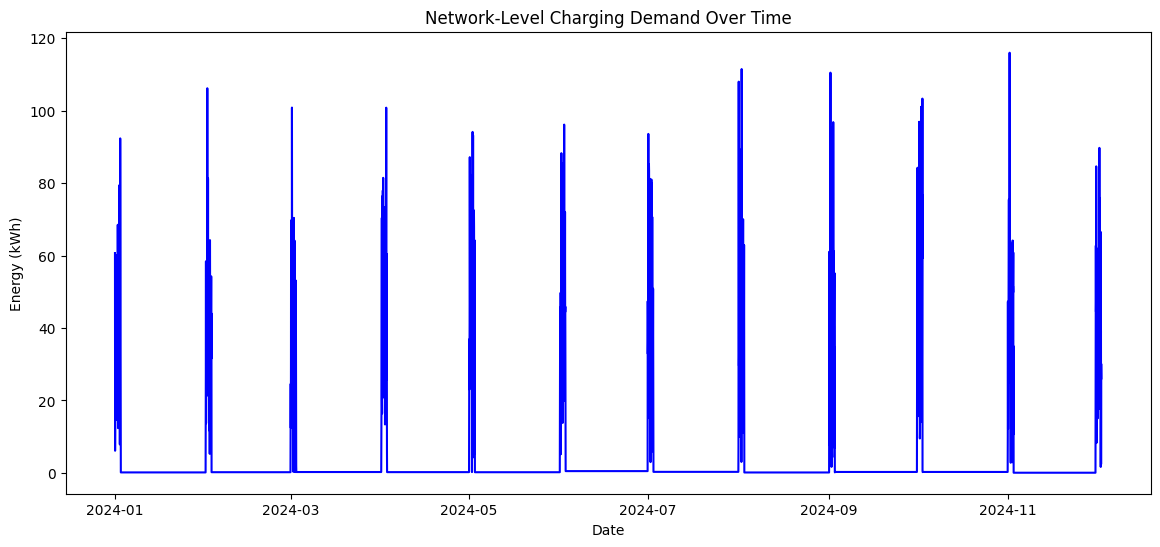

C:\Users\Javagar\AppData\Local\Temp\ipykernel_28760\3970516088.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_usage.index, y=hourly_usage.values, palette="viridis")


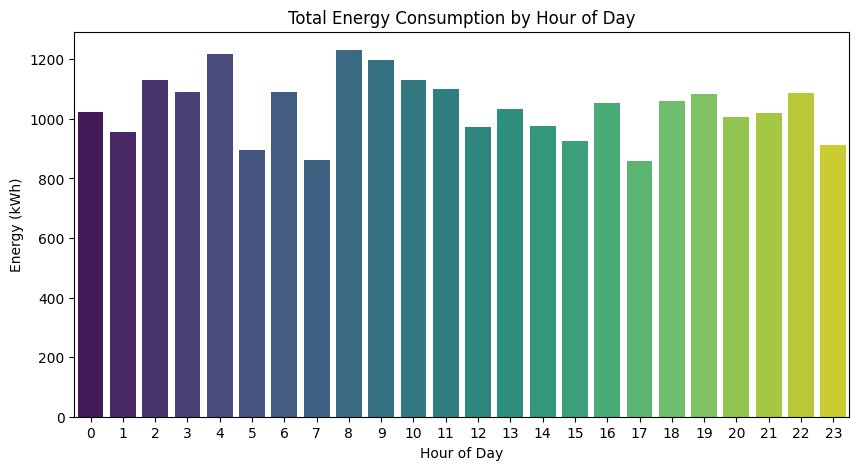

C:\Users\Javagar\AppData\Local\Temp\ipykernel_28760\3970516088.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_usage.index, y=dow_usage.values, palette="magma")


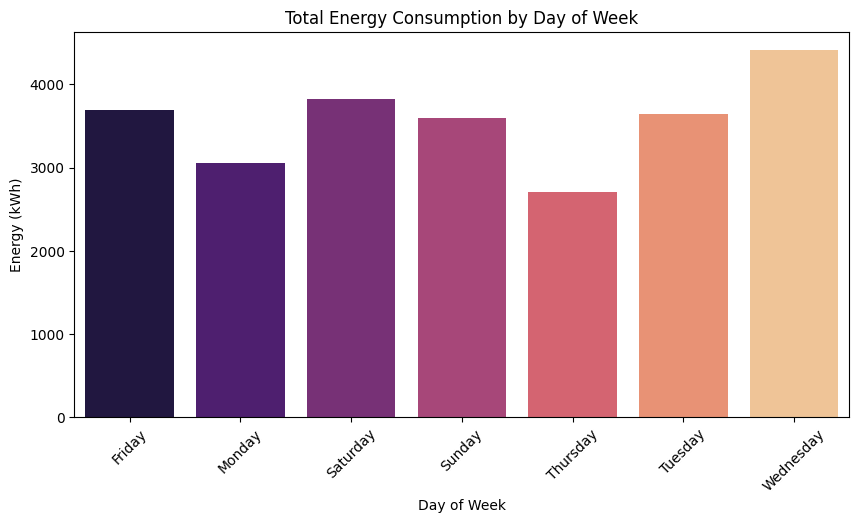

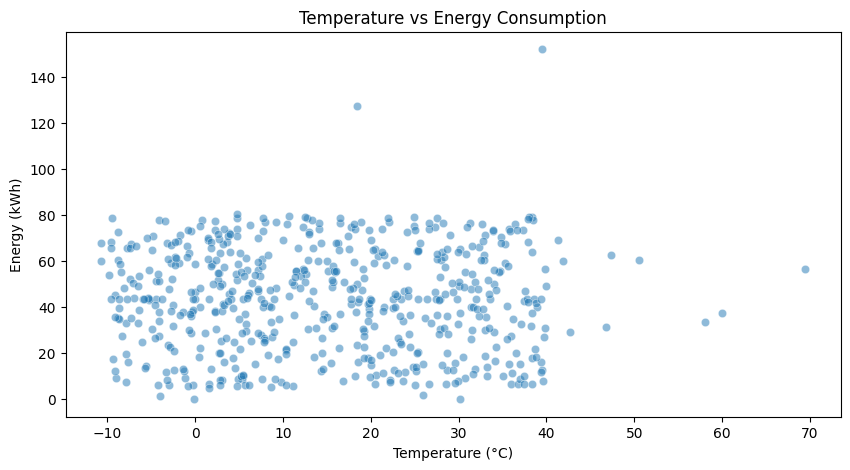


ARIMA Forecast Performance → MAE: 3.71, RMSE: 13.95


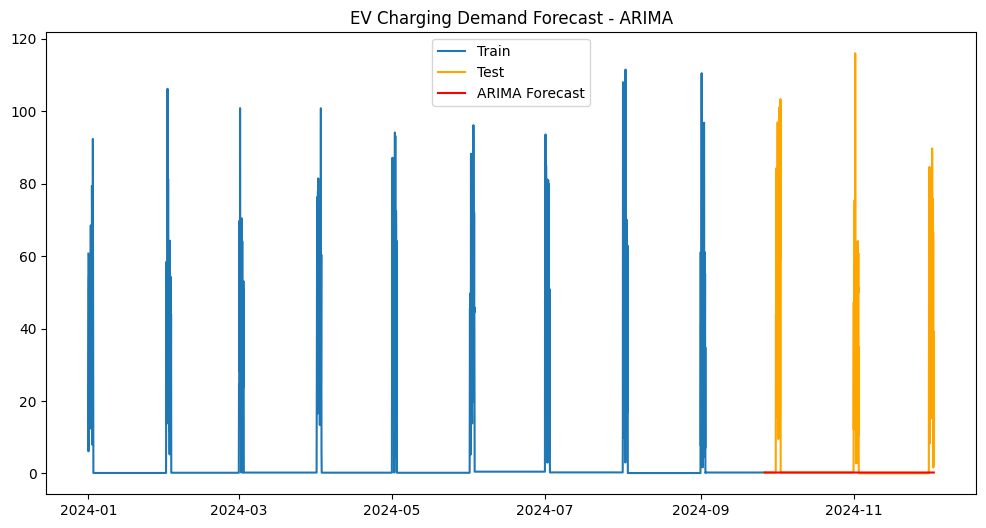


Dashboard KPIs:
- Total Sessions: 572
- Total Energy (MWh): 24.920947698322763
- Peak Hour: 8
- Peak Demand (kWh): 1231.123977313
- Best Weather Condition: Cloudy


In [4]:
# ============================================
# EV Charging Demand Analysis & Forecasting
# Session-Level -> Network -> Station-Level
# Only ARIMA
# ============================================

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# ============================================
# 1. Load Datasets (already cleaned earlier)
# ============================================
sessions = pd.read_csv("final_session_level.csv", parse_dates=["Charging_Start", "Charging_End"])
network_hourly = pd.read_csv("final_network_hourly.csv", parse_dates=["ds"])
station_hourly = pd.read_csv("final_station_hourly.csv", parse_dates=["ds"])

# ============================================
# 2. Relationships between datasets
# ============================================
# sessions -> base dataset
# network_hourly -> aggregate of all sessions per hour
# station_hourly -> aggregate per station per hour

print("Dataset shapes:")
print(f"Sessions: {sessions.shape}")
print(f"Network hourly: {network_hourly.shape}")
print(f"Station hourly: {station_hourly.shape}")

# Check totals match
print("\nTotal Energy Consumed (kWh):")
print(f"Session-level: {sessions['Energy_kWh'].sum():,.2f}")
print(f"Network-hourly: {network_hourly['y'].sum():,.2f}")
print(f"Station-hourly: {station_hourly['y'].sum():,.2f}")

# ============================================
# 3. Exploratory Data Analysis (EDA)
# ============================================

# (A) Charging demand trend
plt.figure(figsize=(14,6))
plt.plot(network_hourly["ds"], network_hourly["y"], color="blue")
plt.title("Network-Level Charging Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.show()

# (B) Peak demand by hour of day
sessions["hour"] = sessions["Charging_Start"].dt.hour
hourly_usage = sessions.groupby("hour")["Energy_kWh"].sum()
plt.figure(figsize=(10,5))
sns.barplot(x=hourly_usage.index, y=hourly_usage.values, palette="viridis")
plt.title("Total Energy Consumption by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Energy (kWh)")
plt.show()

# (C) Peak demand by day of week
dow_usage = sessions.groupby("Day of Week")["Energy_kWh"].sum()
plt.figure(figsize=(10,5))
sns.barplot(x=dow_usage.index, y=dow_usage.values, palette="magma")
plt.title("Total Energy Consumption by Day of Week")
plt.xticks(rotation=45)
plt.ylabel("Energy (kWh)")
plt.show()

# (D) Relationship: Temperature vs Energy
plt.figure(figsize=(10,5))
sns.scatterplot(x=sessions["Temperature (°C)"], y=sessions["Energy_kWh"], alpha=0.5)
plt.title("Temperature vs Energy Consumption")
plt.xlabel("Temperature (°C)")
plt.ylabel("Energy (kWh)")
plt.show()

# ============================================
# 4. ARIMA Forecasting (Network-level)
# ============================================
train_size = int(len(network_hourly) * 0.8)
train = network_hourly.iloc[:train_size]
test = network_hourly.iloc[train_size:]

# Fit ARIMA
p, d, q = 3, 1, 3
arima_model = ARIMA(train["y"], order=(p, d, q))
fit_arima = arima_model.fit()

# Forecast
forecast = fit_arima.forecast(steps=len(test))
forecast = pd.Series(forecast.values, index=test["ds"])

# Evaluate
mae = mean_absolute_error(test["y"], forecast)
rmse = math.sqrt(mean_squared_error(test["y"], forecast))
print(f"\nARIMA Forecast Performance → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test["ds"], test["y"], label="Test", color="orange")
plt.plot(forecast.index, forecast.values, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("EV Charging Demand Forecast - ARIMA")
plt.show()

# ============================================
# 5. Dashboard-ready KPIs
# ============================================
kpis = {
    "Total Sessions": len(sessions),
    "Total Energy (MWh)": sessions["Energy_kWh"].sum() / 1000,
    "Peak Hour": hourly_usage.idxmax(),
    "Peak Demand (kWh)": hourly_usage.max(),
    "Best Weather Condition": sessions.groupby("Weather_Condition")["Energy_kWh"].mean().idxmax()
}

print("\nDashboard KPIs:")
for k, v in kpis.items():
    print(f"- {k}: {v}")

# ============================================
# 6. Save dashboard datasets
# ============================================
network_hourly.to_csv("dashboard_network_hourly.csv", index=False)
station_hourly.to_csv("dashboard_station_hourly.csv", index=False)
sessions.to_csv("dashboard_sessions.csv", index=False)
